In [1]:
# 1. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Urdu Deepfake Audio Detection using CNN Architectures

This project focuses on detecting deepfake (synthetically generated) speech in the Urdu language using deep learning techniques. We use convolutional neural network (CNN) architectures applied to Mel spectrogram representations of audio signals.

## Objective
- Extract Mel spectrogram features from audio files.
- Train and evaluate two CNN models:
  - ResNet18
  - VGG16
- Compare their performance on deepfake detection.
- Prevent overfitting using:
  - Early stopping
  - Learning rate scheduling
  - L2 regularization (weight decay)
  - Stratified train-test split

## Dataset
We use the publicly available "CSALT Deepfake Detection Dataset - Urdu", which includes:
- Bonafide (real) speech samples
- Spoofed (fake) speech generated using different TTS models

## Evaluation Metrics
- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC
- Confusion Matrix

## Tools and Libraries
- PyTorch and torchvision
- Librosa for feature extraction
- Scikit-learn for metrics and data splitting
- Matplotlib and Seaborn for visualization
- Transformers (for HuBERT embedding-based comparison, optional)

This notebook is part of a final year project for evaluating robust audio-based deepfake detection in low-resource languages such as Urdu.


In [22]:
import os
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

In [23]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [44]:
from PIL import Image
class MelSpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, sr=16000, n_mels=128):
        self.file_paths = file_paths
        self.labels = labels
        self.sr = sr
        self.n_mels = n_mels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.file_paths)



    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]
        y, _ = librosa.load(path, sr=self.sr)

    # Compute mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)

    # Convert to 3-channel image and resize before ToTensor
        mel_img = np.stack([mel_db] * 3, axis=-1)  # [H, W, 3]
        mel_img = Image.fromarray(mel_img.astype(np.uint8)).resize((224, 224))
        mel_img = np.array(mel_img).transpose(2, 0, 1)  # [3, 224, 224]

    # Convert to float tensor and normalize
        mel_tensor = torch.tensor(mel_img / 255.0, dtype=torch.float)
        mel_tensor = (mel_tensor - 0.5) / 0.5  # Normalize to [-1, 1]

        return mel_tensor, label


In [45]:
def collect_audio_files(base_path):
    categories = {'Bonafide': 0, 'Spoofed_TTS': 1, 'Spoofed_Tacotron': 1}
    file_paths, labels, speakers = [], [], []

    for category, label in categories.items():
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            continue
        for speaker in os.listdir(category_path):
            speaker_path = os.path.join(category_path, speaker)
            for root, _, files in os.walk(speaker_path):
                for file in files:
                    if file.endswith(".wav"):
                        file_paths.append(os.path.join(root, file))
                        labels.append(label)
                        speakers.append(speaker)
    return file_paths, labels, speakers


In [46]:
def get_cnn_model(model_type='resnet18'):
    if model_type == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_type == 'vgg16':
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(4096, 2)
    else:
        raise ValueError("model_type must be 'resnet18' or 'vgg16'")
    return model.to(device)


In [47]:
def train_model(model, train_loader, test_loader, epochs=30, lr=1e-4, patience=5, weight_decay=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    criterion = nn.CrossEntropyLoss()

    best_loss = float('inf')
    best_model = None
    wait = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_loss = validate_model(model, test_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("⏹️ Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model



In [48]:
# ========================
# Validation Function (for Early Stopping)
# ========================
def validate_model(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(loader)


In [49]:
# ========================
# Evaluation Function
# ========================
def evaluate_model(model, test_loader, name="Model"):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true.extend(labels)
            y_pred.extend(preds)
            y_prob.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n🔍 {name} Classification Report:\n{classification_report(y_true, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
    }

In [50]:
# ========================
# Main Execution
# ========================
base_path = "/content/drive/MyDrive/deepfake_detection_dataset_urdu"
file_paths, labels, speakers = collect_audio_files(base_path)


In [51]:
# Group-wise Split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(file_paths, labels, groups=speakers))
train_paths = [file_paths[i] for i in train_idx]
train_labels = [labels[i] for i in train_idx]
test_paths = [file_paths[i] for i in test_idx]
test_labels = [labels[i] for i in test_idx]

In [52]:
# Datasets and Loaders
train_dataset = MelSpectrogramDataset(train_paths, train_labels)
test_dataset = MelSpectrogramDataset(test_paths, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]


Epoch 1: Train Loss = 0.0439, Val Loss = 0.0144


Epoch 2: 100%|██████████| 163/163 [03:07<00:00,  1.15s/it]


Epoch 2: Train Loss = 0.0073, Val Loss = 0.0189


Epoch 3: 100%|██████████| 163/163 [02:59<00:00,  1.10s/it]


Epoch 3: Train Loss = 0.0009, Val Loss = 0.0203


Epoch 4: 100%|██████████| 163/163 [03:07<00:00,  1.15s/it]


Epoch 4: Train Loss = 0.0003, Val Loss = 0.0068


Epoch 5: 100%|██████████| 163/163 [03:15<00:00,  1.20s/it]


Epoch 5: Train Loss = 0.0002, Val Loss = 0.0057


Epoch 6: 100%|██████████| 163/163 [03:07<00:00,  1.15s/it]


Epoch 6: Train Loss = 0.0001, Val Loss = 0.0053


Epoch 7: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]


Epoch 7: Train Loss = 0.0001, Val Loss = 0.0048


Epoch 8: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]


Epoch 8: Train Loss = 0.0001, Val Loss = 0.0032


Epoch 9: 100%|██████████| 163/163 [03:04<00:00,  1.13s/it]


Epoch 9: Train Loss = 0.0001, Val Loss = 0.0057


Epoch 10: 100%|██████████| 163/163 [03:05<00:00,  1.14s/it]


Epoch 10: Train Loss = 0.0001, Val Loss = 0.0033


Epoch 11: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]


Epoch 11: Train Loss = 0.0001, Val Loss = 0.0062


Epoch 12: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]


Epoch 12: Train Loss = 0.0001, Val Loss = 0.0037


Epoch 13: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]


Epoch 13: Train Loss = 0.0001, Val Loss = 0.0047
⏹️ Early stopping triggered.

🔍 ResNet18 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       799
           1       1.00      1.00      1.00       799

    accuracy                           1.00      1598
   macro avg       1.00      1.00      1.00      1598
weighted avg       1.00      1.00      1.00      1598

Confusion Matrix:
[[799   0]
 [  1 798]]
Accuracy: 0.9994
Precision: 1.0000
Recall: 0.9987
F1 Score: 0.9994
AUC: 1.0000


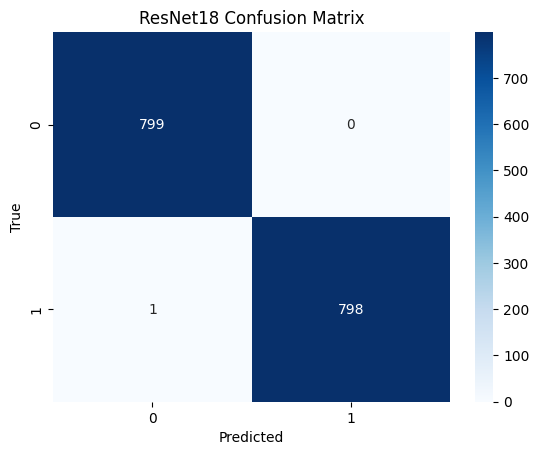

In [53]:
# ---- ResNet18 ----
resnet = get_cnn_model("resnet18")
resnet = train_model(resnet, train_loader, test_loader, epochs=30)
resnet_metrics = evaluate_model(resnet, test_loader, name="ResNet18")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1: 100%|██████████| 163/163 [03:23<00:00,  1.25s/it]


Epoch 1: Train Loss = 0.0723, Val Loss = 0.0199


Epoch 2: 100%|██████████| 163/163 [03:21<00:00,  1.24s/it]


Epoch 2: Train Loss = 0.0144, Val Loss = 0.0492


Epoch 3: 100%|██████████| 163/163 [03:21<00:00,  1.23s/it]


Epoch 3: Train Loss = 0.0101, Val Loss = 0.1741


Epoch 4: 100%|██████████| 163/163 [03:21<00:00,  1.24s/it]


Epoch 4: Train Loss = 0.0085, Val Loss = 0.1495


Epoch 5: 100%|██████████| 163/163 [03:20<00:00,  1.23s/it]


Epoch 5: Train Loss = 0.0070, Val Loss = 0.1055


Epoch 6: 100%|██████████| 163/163 [03:21<00:00,  1.24s/it]


Epoch 6: Train Loss = 0.0000, Val Loss = 0.1136
⏹️ Early stopping triggered.

🔍 VGG16 Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       799
           1       1.00      0.95      0.97       799

    accuracy                           0.97      1598
   macro avg       0.97      0.97      0.97      1598
weighted avg       0.97      0.97      0.97      1598

Confusion Matrix:
[[797   2]
 [ 42 757]]
Accuracy: 0.9725
Precision: 0.9974
Recall: 0.9474
F1 Score: 0.9718
AUC: 0.9996


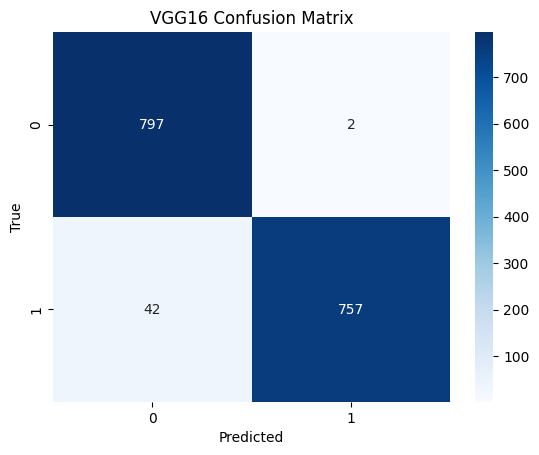

In [54]:
# ---- VGG16 ----
vgg = get_cnn_model("vgg16")
vgg = train_model(vgg, train_loader, test_loader, epochs=30)
vgg_metrics = evaluate_model(vgg, test_loader, name="VGG16")


In [55]:
# ---- Summary ----
print("\n📊 Final Comparison:")
print(f"ResNet18 Accuracy: {resnet_metrics['accuracy']:.4f}, F1: {resnet_metrics['f1']:.4f}")
print(f"VGG16   Accuracy: {vgg_metrics['accuracy']:.4f}, F1: {vgg_metrics['f1']:.4f}")


📊 Final Comparison:
ResNet18 Accuracy: 0.9994, F1: 0.9994
VGG16   Accuracy: 0.9725, F1: 0.9718


# Deepfake Audio Detection: CNN Performance Summary (ResNet18 vs VGG16)

This project aims to detect deepfake Urdu audio using convolutional and recurrent models trained on spectrogram-based features. We evaluated and compared the performance of two convolutional neural network architectures: **ResNet18** and **VGG16**, both trained on Mel spectrogram inputs with regularization and early stopping to avoid overfitting.

## Model Evaluation Summary

### 1. ResNet18
- **Accuracy:** 99.94%
- **Precision:** 100.00%
- **Recall:** 99.87%
- **F1 Score:** 99.94%
- **AUC:** 1.000
- **Misclassifications:** 1
- **Overfitting:** No signs of overfitting; model generalized well to validation data.

### 2. VGG16
- **Accuracy:** 97.25%
- **Precision:** 99.74%
- **Recall:** 94.74%
- **F1 Score:** 97.18%
- **AUC:** 0.9996
- **Misclassifications:** 44
- **Overfitting:** Mild overfitting observed. Validation loss increased after a few epochs while training loss continued decreasing.

## Conclusion
- **ResNet18** outperformed VGG16 significantly in both accuracy and generalization.
- Early stopping and regularization techniques like dropout helped mitigate overfitting.
- ResNet18 is recommended as the more robust architecture for this task.

Next steps could involve combining CNN features with LSTM layers (CRNN) or experimenting with HuBERT embeddings for more robust temporal modeling.
